<a href="https://colab.research.google.com/github/StoneMason495/cap-comp215/blob/main/215Project2ZM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Daisy World: Testing the Gaia Hypothesis
###By: Zach Mason, COMP 215

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
from matplotlib import animation
import time
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

## 2D Animation Class:
For future simulations using Cellular Automata, I took the Animation 2D class that we have used throughout the term, so I take no credit for the creation of this class.

In [2]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [3]:
# Other borrowed elemtns 
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

##Daisy Class:
I created a simple data class to create each daisy, which only has its colour (inputted as a string), and the albedo, or amount of light reflected by a surface in decimal/fraction form (inputted as a float)
I chose the albedo values of 0.25 for black and 0.75 for white, as [this website](https://serc.carleton.edu/NAGTWorkshops/complexsystems/activities/daisyworld.html) utilized those values as well. The 0.75 value means that the white daisies will reflect 75% of the light shone upon them, where as the black daisies (with an albedo of 0.25) will absorb 75% of the light, and therefore the heat

In [4]:
B = lambda T: 1 - 0.003265*(22.5-T)**2 #The rate of growth for the daisies, T is equal to the temperature on the planet/ of the daisies (if T<5 or T>40, then B = 0)
@dataclass
class Daisy: #a dataclass, with only the colour of the daisy, and the albedo value (fractional value of light that a surface reflects)
  color : str
  albedo : float
  pop : float #Must be greater than 0, otherwise no growth can occur in a simulation
  
  def growth_rate(self, temp):
    growth_rate = self.pop * B(temp)
    return growth_rate if growth_rate > 0 else 0
  def death_rate(self, gamma=0.3):
    if self.pop > 0.01:
      return self.pop * gamma
    else:
      return 0
  def step(self):
    return 1

white = Daisy('white', 0.75, 0.001)
black = Daisy('black', 0.25, 0.001)

white.growth_rate(31), black.growth_rate(22.5)
white.death_rate(), black.death_rate()

(0, 0)

##Daisyworld Class:
In order to create a simulation, I created a second class, this time for the whole daisyworld, which takes inputs of a black and white daisy object, as well as leaving the option to lower the percentage of planet available, if one so desired

In [19]:
class Daisyworld:
  def __init__(self, b_daisy, w_daisy, p=1.0):
    '''initialize a Daisyworld object, in preparation for a simulation
    b_daisy : Daisy, choose the object you want to be the black daisies
    w_daisy : Daisy, choose the object you want to be the white daisies
    p : float, amount of fertile ground on planet, designed to be left at 1.0 (100%), but can be changed if desired'''
    self.black = b_daisy #the black daisy used in the simulation, designed to be a daisy class object
    self.white = w_daisy #the white daisy used in the simulation, also designed to be a daisy class object
    self.p = p #the total planet percentage as a decimal, designed to be 1.0, but could in theory be lowered
    self.x = self.p - self.black.pop - self.white.pop #total planet remaining for expansion, utilized in calculations of growth
    self.luminosity = 0.5 #initial value of luminosity, which will then increase each step by (0.02*)
    self.sol_constant = 917
    self.stefboltz = 5.67*(10**-8)
    self.q = 0.2*(self.sol_constant/self.stefboltz)
    self.cycle_num = 0
  
  def dw_temp(self):
    '''calculates the temperature for the year on Daisyworld
    daisyworldtemp = ((solar_flux*(1-planetary_albedo)/stefboltz)^(0.25))-273'''
    temp = (((self.luminosity * self.sol_constant)*(1-self.dw_albedo())/self.stefboltz)**(0.25))-273
    return temp

  def dw_albedo(self):
    '''calculates the albedo (reflective quantity as a decimal/fraction) of the entire planet
    planetary_albedo = (white_daisies*WD_albedo)+(black_daisies*BD_albedo)+(X*bare_ground_albedo(=0.5))'''
    planet_albedo = (self.white.pop * self.white.albedo) + (self.black.pop * self.black.albedo) + (self.x*0.5)
    return planet_albedo

  def daisy_temp(self, daisy):
    '''Calculate the temperature of one of either black or white daisies in a daisyworld simulation
    D_temp = ((q*(planetary_albedo-D_albedo)+((daisyworld__temp+273)^4))^(0.25))-273'''
    d_temp = ((self.q*(self.dw_albedo()-daisy.albedo)+((self.dw_temp()+273)**4))**0.25)-273
    return d_temp

  def ground_temp(self):
    '''ground temperature = ((q*(planetary_albedo - bare_ground_albedo) + ((daisyworld__temp + 273)^4))^(0.25))-273'''
    g_temp = ((self.q*(self.dw_albedo-0.5) + ((self.dw_temp()+273)**4))**(0.25))-273
    return g_temp

  def step(self):
    '''Advances the simulation one timestep'''
    planet_temp = self.dw_temp()
    bd_temp = self.daisy_temp(self.black)
    wd_temp = self.daisy_temp(self.white)
    self.black.pop = self.black.pop + (self.black.growth_rate(bd_temp)*self.x)-self.black.death_rate() #calculates the population of black daisies
    self.white.pop = self.white.pop + (self.white.growth_rate(wd_temp)*self.x)-self.white.death_rate() #calculates the population of white daisies
    self.x = self.p - self.black.pop - self.white.pop
    planet_albedo = self.dw_albedo()
    self.cycle_num += 1
    self.luminosity += (0.02*self.cycle_num) if self.luminosity < 1 else 0


world = Daisyworld(black, white)
frames = 100
b_daisypop = []
w_daisypop = []
x_remaining = []
for i in range(frames):
  world.step()
  b_daisypop.append(world.black.pop)
  w_daisypop.append(world.white.pop)
  x_remaining.append(world.x)
# b_daisypop = b_daisypop[40:]
# w_daisypop = w_daisypop[40:]
# x_remaining = x_remaining[40:]
plt.plot(range(frames), b_daisypop)
plt.plot(range(frames), w_daisypop)
plt.plot(range(frames), x_remaining)
plt.show()

0.5657620194420939

## Expanding the Daisyworld Class: Transitioning to Cellular Automata

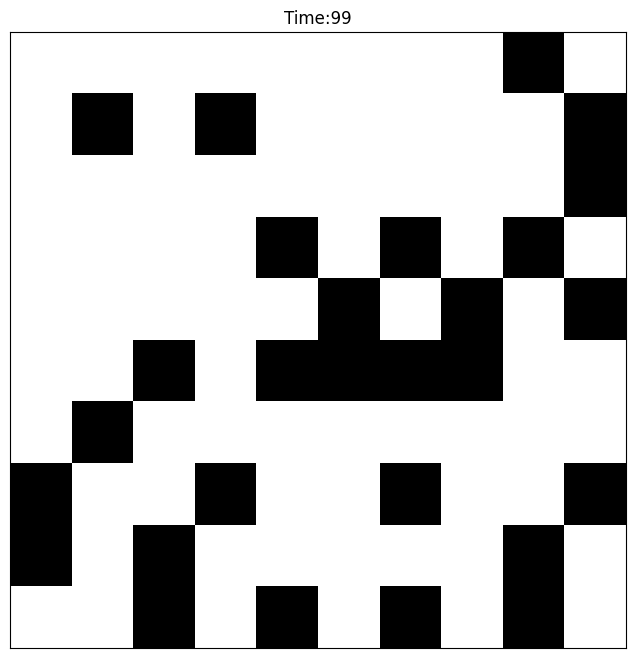

In [46]:
class Daisyworld_CA(Daisyworld):
  kernel = np.array([[0, 1, 0],
                    [1, 1, 1],
                    [0, 1, 0]])
  #Define three possible states for the Daisyworld simulation
  BARREN = 0
  BLACK = 1
  WHITE = 2

  #Creating a colour map for each colour
  cmap = [(0.6, 0.6, 0.7), (0, 0, 0), (1, 1, 1)]
  dw_colour_map = matplotlib.colors.ListedColormap(cmap)

  def __init__(self, b_daisy, w_daisy, rows, p=1.0):
    '''initialize a Daisyworld object, in preparation for a simulation
    b_daisy : Daisy, choose the object you want to be the black daisies
    w_daisy : Daisy, choose the object you want to be the white daisies
    p : float, amount of fertile ground on planet, designed to be left at 1.0 (100%), but can be changed if desired'''
    Daisyworld.__init__(self, b_daisy, w_daisy, p=p)
    self.rows = rows
    self.array = np.random.choice([self.BARREN, self.BLACK, self.WHITE], (rows, rows), p=[0.9, 0.05, 0.05])

  def bd_growth(self):
    bd_temp = self.daisy_temp(self.black)
    bd_growth = (self.black.growth_rate(bd_temp)*self.x)-self.black.death_rate() #calculates the population of black daisies
    bd_growth = 0 if bd_growth < 0 else bd_growth
    return bd_growth

  def wd_growth(self):
    wd_temp = self.daisy_temp(self.white)
    wd_growth = self.white.pop + (self.white.growth_rate(wd_temp)*self.x)-self.white.death_rate() #calculates the population growth of white daisies
    wd_growth = 0 if wd_growth < 0 else wd_growth
    return wd_growth

  def step(self):
    planet_temp = self.dw_temp()
    c = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
    barren = (self.array == self.BARREN) #unoccupied land, that will continue to be unoccupied in the next timestep
    black = (self.array == self.BLACK) #unoccupied land, will become a black daisy in the next timestep
    white = (self.array == self.WHITE) #unoccupied land, will become a white daisy in the next timestep
    soon_white = (self.array == self.BARREN) & (c>=2)
    soon_black = (self.array == self.BARREN) & (c<2)
    near_daisy = (self.array == self.BARREN) & (c>1)
    # self.array[black] = np.random.choice([self.BARREN, self.BLACK], self.array[black].shape, p=[1-self.bd_growth(), self.bd_growth()])
    # self.array[black] = self.BLACK
    # self.array[white] = np.random.choice([self.BARREN, self.WHITE], self.array[white].shape, p=[1-self.wd_growth(), self.wd_growth()])
    # self.array[white] = self.WHITE
    self.array[near_daisy] = np.random.choice([self.BARREN, self.BLACK, self.WHITE], self.array[near_daisy].shape, p=[self.x, self.black.pop, self.white.pop])
    self.cycle_num += 1
    self.luminosity += (0.02*self.cycle_num) if self.luminosity < 1 else 0

  def draw(self, axes=None, step=''): #Needed for the Animation2D class, taken from previous labs
    """Draws the CA cells using the colour map so values are coloured intuitively."""
    axes = axes or plt.gca()
    title = f'Time:{step}'
    plot_2D_array(self.array, axes=axes, title=title,
                  cmap=self.dw_colour_map, vmin=0, vmax=len(self.dw_colour_map.colors))
    
CA_world = Daisyworld_CA(black, white, 10)
CA_world.array

Anim = Animation2D(CA_world, frames=100)
Anim.animate()